# (23) MNIST — ZeroInit — 0

**Motivation**: Init as all zeros. Device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Import $/$ prep

In [2]:
from _tmp.gapvae import prepare_stuff, iteration, validate
from _tmp.plotters import plot_latent_space, plot_latent_scatter

In [3]:
n_latents = 20
weight_norm = True

batch_size = 300
epochs = 1200

pvae, optim, optim_schedule, trn, vld, device, kws_iter = prepare_stuff(
    device_idx=0,
    n_latents=n_latents,
    max_grad_norm=500,
    batch_size=batch_size,
    epochs=epochs,
    lr=1e-3,
    beta=1.0,
)

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  PoissonVAE |  7.8 Mil   |
|     ---     |    ---     |
|     enc     |  6.6 Mil   |
|    fc_enc   |    660     |
|     dec     |  1.2 Mil   |
|    fc_dec   |   21.5 K   |
+-------------+------------+

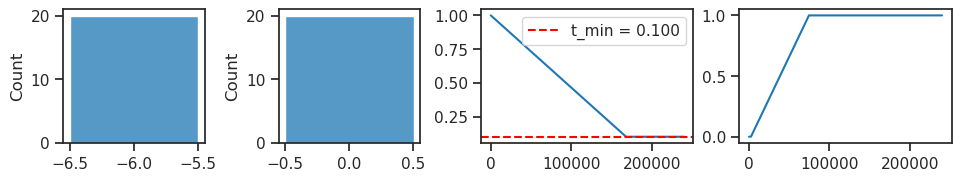

In [4]:
fig, axes = create_figure(1, 4, (9.5, 1.7), width_ratios=[1, 1, 1.5, 1.5], layout='constrained')

sns.histplot(to_np(pvae.log_rates).ravel(), ax=axes[0])
sns.histplot(to_np(pvae.log_rates.exp()).ravel(), ax=axes[1])
axes[2].plot(kws_iter['temperatures'])
axes[3].plot(kws_iter['beta_values'])
_t = kws_iter['temperatures'].min()
axes[2].axhline(_t, color='r', ls='--', label=f't_min = {_t:0.3f}')
axes[2].legend()
plt.show()

## Train / Validate

### trn

In [5]:
%%time

pbar = tqdm(range(epochs), ncols=130, position=0)
nelbo, grads = np.zeros(epochs), np.zeros(epochs)

for ep in pbar:
    grad, tot, recon, kl, r_max = iteration(
        ep, pvae, trn, optim, optim_schedule, device, **kws_iter)
    nelbo[ep], grads[ep] = recon + 1.0 * kl, grad

    msg = ',  '.join([
        f"grad = {grad:0.1f}",
        f"r_max = {r_max:0.1f}",
        f"loss = (kl: {kl:0.1f}, recon: {recon:0.1f}  ——  tot: {tot:0.2f})  ",
    ])
    pbar.set_description(msg)

grad = 74.9,  r_max = 5.2,  loss = (kl: 8.8, recon: 23.8  ——  tot: 32.64)  : 100%|██████████| 1200/1200 [3:09:25<00:00,  9.47s/it]

CPU times: user 5h 17min 8s, sys: 2min 24s, total: 5h 19min 32s
Wall time: 3h 9min 25s


grad = 68.5,  loss = (kl: 10.0, recon: 19.1  ——  tot: 29.13)  : 100%|███████████████████████| 1200/1200 [3:06:13<00:00,  9.31s/it]

CPU times: user 5h 9min 3s, sys: 2min 21s, total: 5h 11min 24s
Wall time: 3h 6min 13s


### vld

In [6]:
loss_vld = validate(pvae, vld, device)
loss_vld

{'kl': 8.81235450894225, 'recon': 24.006932588465073, 'tot': 32.81928691789216}

In [7]:
## Was t = 1.0 --> 0.2

{'kl': 10.009074730966606,
 'recon': 19.283029114966297,
 'tot': 29.29210398954504}

In [7]:
## Was t = 0.5

{'kl': 10.238961349188113,
 'recon': 18.553320396273744,
 'tot': 28.792281757429535}

In [10]:
## Was portion=0.5

{'kl': 9.779404584099266,
 'recon': 19.297706765567558,
 'tot': 29.077111098345586}

In [6]:
### Was beta=0.6, with enc act: 'exp'

{'kl': 17.94726452636719,
 'recon': 19.887100146484375,
 'tot': 30.655459423828123}

In [9]:
### Was with self.dt included

{'kl': 16.8736869140625, 'recon': 21.57813173828125, 'tot': 31.70234443359375}

In [8]:
### delta_t = [26.4626] —— Was n_latents = 100, beta=0.6, batch_size=200

{'kl': 4.683330206298828,
 'recon': 7.804767846679688,
 'tot': 10.614766052246093}

In [7]:
### Was n_latents = 1000, beta=0.6, batch_size=2000

{'kl': 16.87740234375, 'recon': 20.002710546875, 'tot': 30.12915234375}

In [7]:
### Was n_latents = 1000, beta=0.8, batch_size=2000

{'kl': 13.758321484375, 'recon': 22.255551953125, 'tot': 33.26221015625}

In [6]:
### Was n_latents = 1000, beta=0.7

{'kl': 14.2896685546875, 'recon': 23.304612499999998, 'tot': 33.30738007812501}

In [8]:
### Was n_latents = 1000, beta=0.2

{'kl': 34.055227929687504,
 'recon': 14.32718876953125,
 'tot': 21.138234472656254}

In [5]:
### Was n_latents = 100, beta=1.0

{'kl': 11.51728046875, 'recon': 24.29022021484375, 'tot': 35.80750117187499}

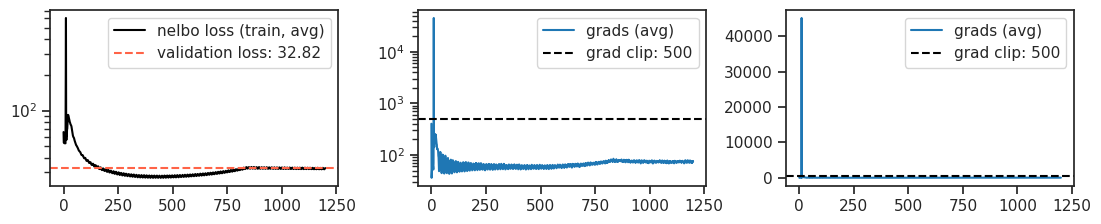

In [7]:
fig, axes = create_figure(1, 3, (11, 2.4), layout='tight')

axes[0].plot(nelbo, color='k', label='nelbo loss (train, avg)')
axes[0].axhline(loss_vld['tot'], color='tomato', ls='--', label=f"validation loss: {loss_vld['tot']:0.2f}")
axes[0].legend()

for ax in axes[1:].flat:
    ax.plot(grads, label='grads (avg)')
    ax.axhline(kws_iter['max_grad_norm'], color='k', ls='--', label=f"grad clip: {kws_iter['max_grad_norm']}")
    ax.legend()
for i in range(2):
    axes[i].set_yscale('log')
# axes[0].set_ylim(top=50)
plt.show()

In [8]:
pvae.temp

0.1

In [9]:
pvae.temp = 0.0

In [10]:
spks, r_q, r_qp = [], [], []

for x, _ in iter(vld):
    x = x.to(device)

    with torch.inference_mode():
        out = pvae(x)

    spks.append(to_np(out['spks']))
    r_q.append(to_np(out['log_dr'].exp()))
    # r_p.append(to_np(out['log_r'].exp()))
    r_qp.append(to_np(torch.exp(out['log_r'] + out['log_dr'])))

spks, r_q, r_qp = cat_map([spks, r_q, r_qp])

In [11]:
np.quantile(spks.ravel(), 1.0)

15.0

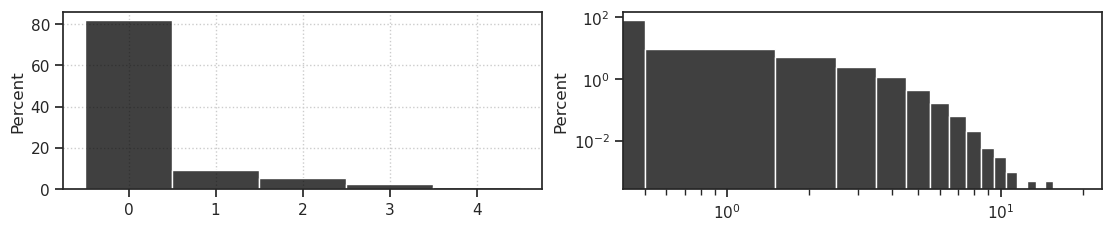

In [12]:
fig, axes = create_figure(1, 2, (11, 2.2), layout='constrained')

nbins = 5
sns.histplot(spks.ravel(), color='k', stat='percent', bins=np.linspace(0, nbins, nbins+1) - 0.5, ax=axes[0])
nbins = 20
sns.histplot(spks.ravel(), color='k', stat='percent', bins=np.linspace(0, nbins, nbins+1) - 0.5, ax=axes[1])

axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[0].grid()

plt.show()

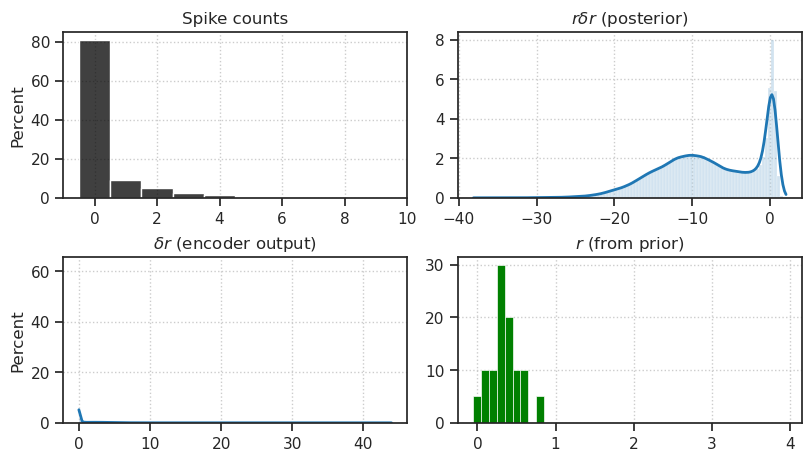

In [13]:
fig, axes = create_figure(2, 2, (8, 4.5), layout='constrained')

nbins = 10
_kws = dict(
    legend=False, 
    stat='percent',
    bins=np.linspace(0, nbins, nbins+1) - 0.5,
    color='k',
)
sns.histplot(spks.ravel(),  ax=axes[0, 0], **_kws)
# axes[0, 0].locator_params(axis='x', nbins=nbins+2)

_kws = dict(
    kde=True,
    legend=False, 
    stat='percent',
    line_kws={'lw': 2},
    alpha=0.2,
)
sns.histplot(r_q.ravel(), ax=axes[1, 0], **_kws)
sns.histplot(np.log(r_qp.ravel()),  ax=axes[0, 1], **_kws)
_kws.update(dict(kde=False, alpha=1.0, color='g', bins=np.linspace(0, 4, 41) - 0.05))
sns.histplot(to_np(pvae.log_rates.exp()).ravel(), ax=axes[1, 1], **_kws)

axes[0, 0].set_title('Spike counts')
axes[0, 1].set_title(r'$r \delta r$' + ' (posterior)')

axes[1, 0].set_title(r'$\delta r$' + ' (encoder output)')
axes[1, 1].set_title(r'$r$' + ' (from prior)')

# axes[1, 0].set_ylim(top=350)

for ax in axes[:, 1]:
    ax.set_ylabel('')

add_grid(axes)

plt.show()

In [14]:
from torchvision.utils import make_grid

t = 0.0
x_samples = pvae.sample(50, t)

grid_images = make_grid(x_samples, nrow=10, normalize=True, value_range=(0, 1))
grid_images.shape

torch.Size([3, 152, 302])

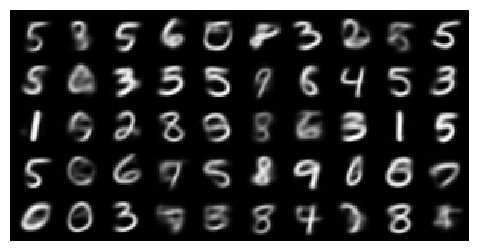

In [15]:
x2p = to_np(grid_images)
x2p = np.transpose(x2p, (1, 2, 0))

fig, ax = create_figure(1, 1, (10, 3))
ax.imshow(x2p)
remove_ticks(ax)
plt.show()

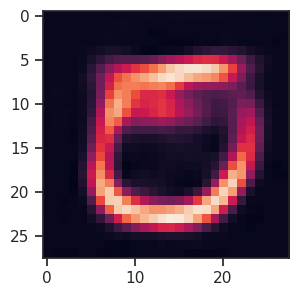

In [16]:
plt.imshow(to_np(x_samples[4].squeeze()));

In [17]:
x, _ = next(iter(vld))
x = x.to(device)
with torch.inference_mode():
    out = pvae(x)

num = 32
grid_images = make_grid(
    torch.cat([x[:num], out['x_recon'][:num]]),
    nrow=num,
    normalize=True,
    value_range=(0, 1),
)

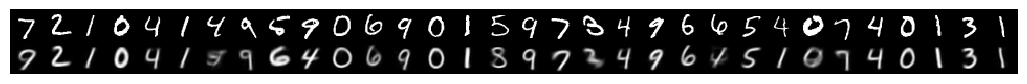

In [18]:
x2p = to_np(grid_images)
x2p = np.transpose(x2p, (1, 2, 0))

fig, ax = create_figure(1, 1, (13, 5))
ax.imshow(x2p)
remove_ticks(ax)
plt.show()

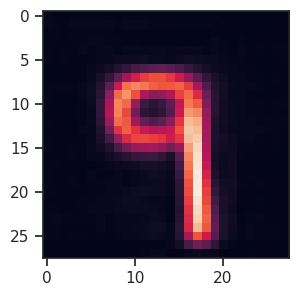

In [19]:
plt.imshow(to_np(out['x_recon'].squeeze()[7]));

In [20]:
spks.shape

(10000, 20)

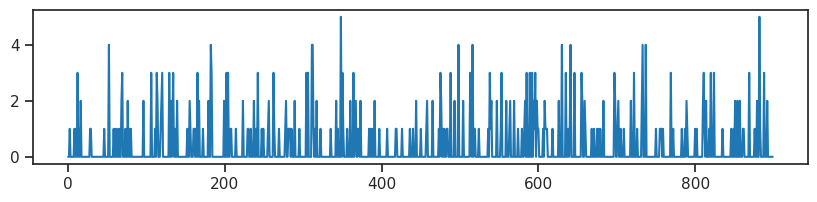

In [31]:
intvl = range(100, 1000)

fig, ax = create_figure(1, 1, (10, 2))
ax.plot(spks[intvl, 8])
plt.show()

In [32]:
pvae.temp = 0.0

In [33]:
spks, r_q, r_qp = [], [], []

for x, _ in iter(vld):
    x = x.to(device)

    with torch.inference_mode():
        out = pvae(x)

    spks.append(to_np(out['spks']))
    r_q.append(to_np(out['log_dr'].exp()))
    # r_p.append(to_np(out['log_r'].exp()))
    r_qp.append(to_np(torch.exp(out['log_r'] + out['log_dr'])))

spks, r_q, r_qp = cat_map([spks, r_q, r_qp])
spks = spks.astype(int)

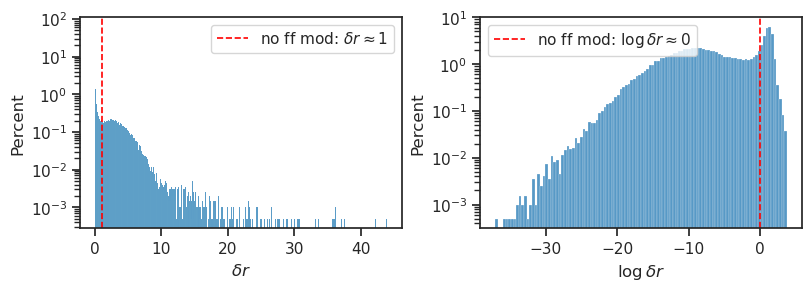

In [34]:
fig, axes = create_figure(1, 2, (8, 2.8), layout='constrained')

x2p = to_np(r_q).ravel()
for i, ax in enumerate(axes.flat):
    # dr
    sns.histplot(x2p if i == 0 else np.log(x2p), stat='percent', ax=ax)
    # log dr
    lbl = r"$\delta r \approx 1$" if i == 0 else r"$\log \delta r \approx 0$"
    lbl = 'no ff mod: ' + lbl
    ax.axvline(1.0 if i == 0 else 0.0, color='r', ls='--', lw=1.2, label=lbl)
    xlbl = r"$\delta r$" if i == 0 else r"$\log \delta r$"
    ax.set_xlabel(xlbl)
    ax.set_yscale('log')
    ax.legend()

plt.show()

## MEI

In [35]:
def compute_mei(model, idx, start, excite=True, alpha=0.1, nsteps=100, scalefunc=lambda x: 1, eps=1e-3, name=''):
    """
        Find an MEI for a given model and neuron ids.

        -model: a pytorch model
        -cids: a list of neuron ids
        -start: the initial input
        -alpha: the learning rate
        -nsteps: the number of steps to run
        -scalefunc: scales the learning rate as a func of step
        -eps: the convergence threshold
        -name: name for printing
    """

    x = start.clone()
    assert len(x) == 1

    pbar = tqdm(range(nsteps), leave=False, position=0)
    for i in pbar:
        model.zero_grad()
        x_copy = x.clone()

        # Get the current prediction
        out = model(x)
        log_dr = out['log_dr'][0, idx]

        if excite:
            y = log_dr
        else:
            y = log_dr.mul(-1)

        # Get the gradient of output with respect to input
        g = torch.autograd.grad(y, x, retain_graph=True)[0]
        g_norm = torch.norm(g)

        if g is None or g_norm == 0:
            print("No gradient at step", i)
            return None

        # Update tqdm description
        msg = f"idx = {idx}  ———  ||g|| = {g_norm:0.5f}"
        pbar.set_description(msg)

        # Update the input
        x = x_copy + scalefunc(i) * alpha * g

        # Terminate if converged
        if torch.abs(x - x_copy).max() < eps:
            print(name, "converged at step", i)
            break

    x = (x - x.mean()) / x.std()
    return x

In [36]:
rng = get_rng()

start = rng.normal(size=(1, 1, 28, 28))
start = torch.nn.Parameter(
    data=torch.tensor(start).float(),
    requires_grad=True,
)
start = start.to(device)

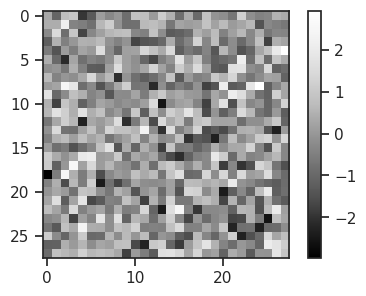

In [37]:
plt.imshow(to_np(start.squeeze()), cmap='Greys_r')
plt.colorbar();

In [38]:
latent_i = 8

In [39]:
%%time

mei = compute_mei(
    model=pvae,
    idx=latent_i,
    start=start,
    excite=True,
    nsteps=10000,
    alpha=0.1,
)

idx = 8  ———  ||g|| = 0.06977:  14%|▉      | 1355/10000 [00:23<02:39, 54.24it/s]

converged at step 1360

CPU times: user 23.9 s, sys: 169 ms, total: 24.1 s
Wall time: 23.8 s


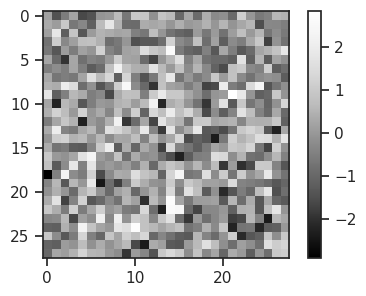

In [40]:
plt.imshow(to_np(mei.squeeze()), cmap='Greys_r')
plt.colorbar();

In [41]:
%%time

mii = compute_mei(
    model=pvae,
    idx=latent_i,
    start=start,
    excite=False,
    nsteps=10000,
    alpha=0.1,
)

CPU times: user 3min 6s, sys: 1.29 s, total: 3min 7s
Wall time: 3min 5s


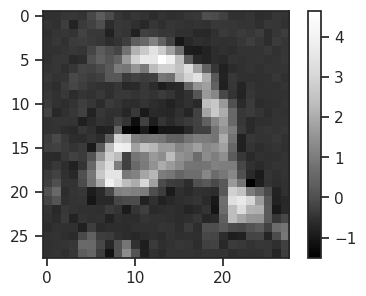

In [42]:
plt.imshow(to_np(mii.squeeze()), cmap='Greys_r')
plt.colorbar();

idx = 0  ———  ||g|| = 0.06080:  32%|██▏    | 6402/20000 [02:03<04:15, 53.19it/s]

converged at step 6407

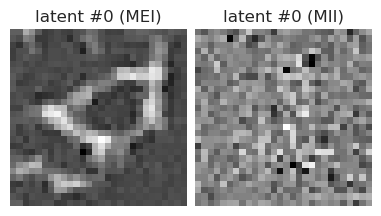

idx = 1  ———  ||g|| = 0.07188:   7%|▌      | 1450/20000 [00:26<05:45, 53.68it/s]

converged at step 1450

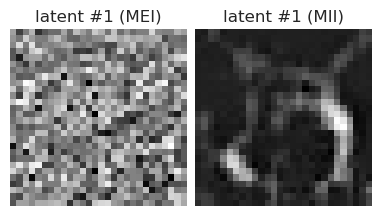

idx = 2  ———  ||g|| = 0.06676:   6%|▍      | 1260/20000 [00:23<05:48, 53.81it/s]

converged at step 1261

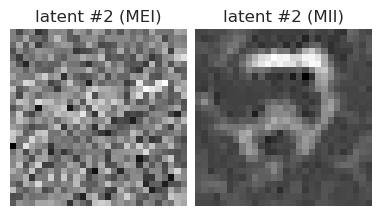

idx = 3  ———  ||g|| = 0.05795:  17%|█▏     | 3381/20000 [01:02<05:11, 53.41it/s]

converged at step 3385

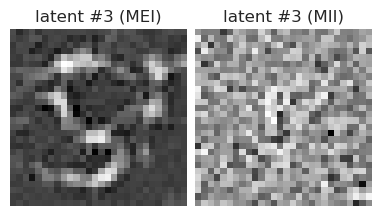

idx = 13  ———  ||g|| = 2.00843:  92%|████▌| 18429/20000 [05:38<00:29, 53.13it/s]

In [ ]:
%%time

mei_all = []
mii_all = []

kws = dict(
    model=pvae,
    idx=None,
    start=start,
    nsteps=20000,
    alpha=0.1,
)
for idx in range(n_latents):
    kws['idx'] = idx
    mei = compute_mei(excite=True, **kws)
    mii = compute_mei(excite=False, **kws)
    mei_all.append(mei)
    mii_all.append(mii)

    fig, axes = create_figure(1, 2, (3.7, 2.1), 'all', 'all', layout='constrained')
    axes[0].imshow(to_np(mei.squeeze()), cmap='Greys_r')
    axes[1].imshow(to_np(mii.squeeze()), cmap='Greys_r')
    axes[0].set_title(f'latent #{idx} (MEI)')
    axes[1].set_title(f'latent #{idx} (MII)')
    remove_ticks(axes)
    plt.show()

In [ ]:
mei_all = torch.cat(mei_all).squeeze()
mii_all = torch.cat(mii_all).squeeze()
mei_all.shape, mii_all.shape

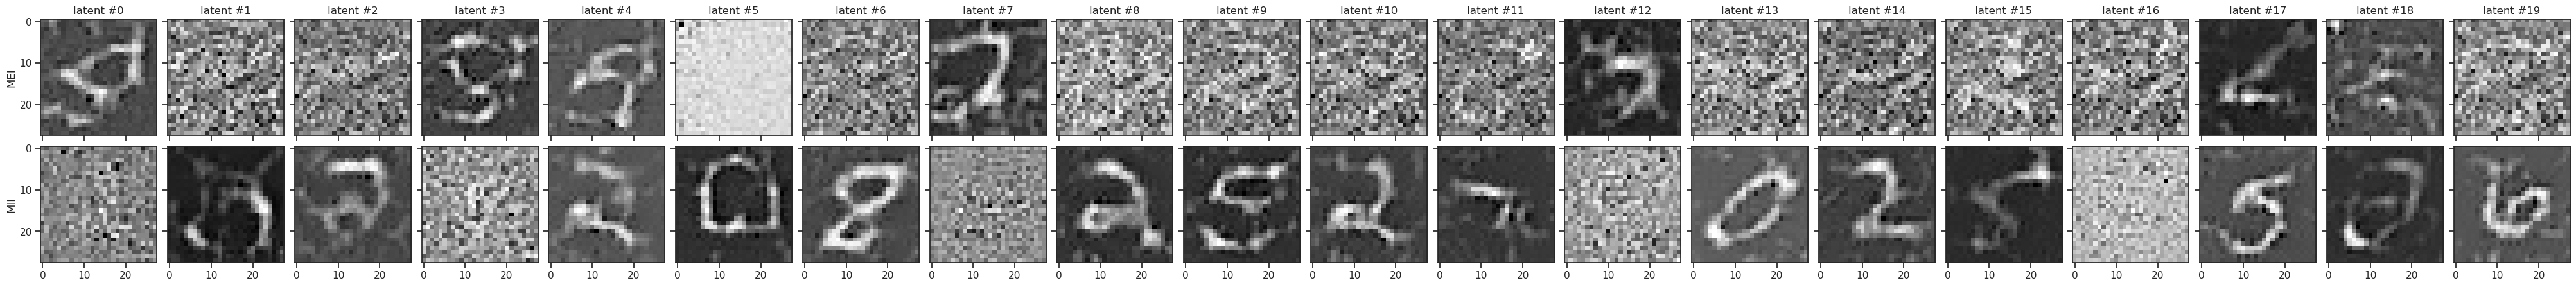

In [49]:
fig, axes = create_figure(2, n_latents, (2 * n_latents, 4.3), 'all', 'all', layout='constrained')

for i in range(n_latents):
    axes[0, i].set_title(f'latent #{i}')
    axes[0, i].imshow(to_np(mei_all[i]), cmap='Greys_r')
    axes[1, i].imshow(to_np(mii_all[i]), cmap='Greys_r')

axes[0, 0].set_ylabel('MEI')
axes[1, 0].set_ylabel('MII')

plt.show()